# Alexa Prize Coding Challenge
## Scalable Intent Classification Service

### Install pip Libraries

In [1]:
!pip install wget tensorflow pandas numpy keras tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 4.8 MB/s 
     |████████████████████████████████| 588.3 MB 20 kB/s 
INFO: pip is looking at multiple versions of tensorflow-text to determine which version is compatible with other requirements. This could take a while.
     |████████████████████████████████| 5.9 MB 58.5 MB/s 
     |████████████████████████████████| 578.1 MB 8.2 kB/s 
     |████████████████████████████████| 578.1 MB 7.0 kB/s 
     |████████████████████████████████| 4.6 MB 71.6 MB/s 
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=9a20ddc9e77cf20d8af5b856e0baa72a84114d6aafd6278b77664a296581002a
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


### Download Datasets
The Wizard of tasks datasets for both the _cooking_ and the _diy_ domains are downloaded from the source.

In [2]:
import wget
url = 'https://wizard-of-tasks.s3.us-west-2.amazonaws.com/wizard_of_tasks_cooking_v1.0.json'
wget.download(url)

url = 'https://wizard-of-tasks.s3.us-west-2.amazonaws.com/wizard_of_tasks_diy_v1.0.json'
wget.download(url)

'wizard_of_tasks_diy_v1.0.json'

### Segregate Data
The data for the two domains is combined and is segregated into train, test and validation JSON files. Care is taken to ignore samples where `text == null` or `intent == null`.

In [3]:
import json
train_json = {}
validation_json = {}
test_json = {}
traincounter = 0
validationcounter = 0
testcounter = 0

# extract and clean training, validation and test data for the cooking domain
with open("wizard_of_tasks_cooking_v1.0.json") as f:
  cooking_data = json.load(f)

  for key in cooking_data.keys():
    for item in cooking_data[key]['turns']:
      if not item["text"] or not item["intent"]:
        continue
      if cooking_data[key]['data_split'] == 'train':
        train_json[traincounter] = {"text": item["text"], "intent": item["intent"]}
        traincounter += 1
      elif cooking_data[key]['data_split'] == 'validation':
        validation_json[validationcounter] = {"text": item["text"], "intent": item["intent"]}
        validationcounter += 1
      else:
        test_json[testcounter] = {"text": item["text"], "intent": item["intent"]}
        testcounter += 1

# extract and clean training, validation and test data for the diy domain
with open("wizard_of_tasks_diy_v1.0.json") as f:
  diy_data = json.load(f)

  for key in diy_data.keys():
    for item in diy_data[key]['turns']:
      if not item["text"] or not item["intent"]:
        continue
      if diy_data[key]['data_split'] == 'train':
        train_json[traincounter] = {"text": item["text"], "intent": item["intent"]}
        traincounter += 1
      elif diy_data[key]['data_split'] == 'validation':
        validation_json[validationcounter] = {"text": item["text"], "intent": item["intent"]}
        validationcounter += 1
      else:
        test_json[testcounter] = {"text": item["text"], "intent": item["intent"]}
        testcounter += 1

with open("train.json", "w") as trj:
  json.dump(train_json, trj)

with open("test.json", "w") as tej:
  json.dump(test_json, tej)

with open("validation.json", "w") as vj:
  json.dump(validation_json, vj)

### Change Data to Dataframes
All of train, test and validation data is changed to a pandas dataframe object for easier processing.

In [4]:
import pandas as pd
train_df = pd.read_json('train.json')
validation_df = pd.read_json('validation.json')
test_df = pd.read_json('test.json')

In [5]:
trainfeatures=train_df.T.copy()
trainlabels=trainfeatures.pop("intent")
trainfeatures = trainfeatures.values
trainfeatures

array([['How much cream cheese and other ingredients will I need?'],
       ["You will need 1 package of cream cheese and a few others. I've shared a list below"],
       ['What are the few other ingredients?'],
       ...,
       ['How long does onions take to fully grow before I can harvest it?'],
       ['It will take between 60-80 days. Keep an eye on them! '],
       ['Thanks for the help!']], dtype=object)

In [6]:
from sklearn.preprocessing import LabelBinarizer
binarizer=LabelBinarizer()
trainlabels=binarizer.fit_transform(trainlabels.values)
trainlabels.shape

(14791, 11)

In [7]:
testfeatures=test_df.T.copy()
testlabels=testfeatures.pop("intent")
validfeatures=validation_df.T.copy()
validlabels=validfeatures.pop("intent")

testfeatures=testfeatures.values
validfeatures=validfeatures.values

testlabels=binarizer.transform(testlabels.values)
validlabels=binarizer.transform(validlabels.values)

### Model Selection
The following maps allow easier selection of pre-processing models and training models from TF Hub. The BERT uncased model and its corresponding pre-processing model has been currently selected for training.

In [42]:
bert_model_name = 'small_bert/bert_en_uncased_L-2_H-256_A-4' 
map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/2',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/2',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2


### Loading and Exploring the model
The selected model and its pre-process model are loaded and explored.

In [9]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import seaborn as sns
from pylab import rcParams

import matplotlib.pyplot as plt
tf.get_logger().setLevel('ERROR')

In [31]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [11]:
trainfeatures[0]

array(['How much cream cheese and other ingredients will I need?'],
      dtype=object)

In [12]:
text_test = trainfeatures[0]
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [  101  2129  2172  6949  8808  1998  2060 12760  2097  1045  2342  1029]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [32]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1
Pooled Outputs Shape:(1, 256)
Pooled Outputs Values:[ 0.92847794  0.2080874  -0.99992836 -0.9924587   0.41474763  0.11426817
 -0.9998523   0.41328043  0.9786404   0.04599417 -0.02448844  0.9333379 ]
Sequence Outputs Shape:(1, 128, 256)
Sequence Outputs Values:[[ 1.7882295  -1.1795938   1.0593735  ...  0.4894876  -0.16682029
   0.05278655]
 [ 0.0127858   0.95934767 -0.6624125  ...  1.2110734  -0.03455648
  -0.35652056]
 [-0.79713994  1.3084714  -0.42945123 ...  0.6995921   0.44968468
  -1.0412076 ]
 ...
 [ 0.8000594  -1.4695652  -0.29270327 ...  0.47258088 -0.20838356
   0.88051254]
 [-0.5030656  -0.46818513  0.25346762 ...  0.98166054  0.84349906
   0.58498025]
 [ 0.6888838  -1.0293688   0.6704462  ...  0.35552356 -0.17352483
  -0.48628923]]


### Defining a Custom Model
A fine-tuned model is created with the preprocessing model, the selected BERT model, one Dense and a Dropout layer.

In [43]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(11, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [44]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(trainfeatures[0]))
print(tf.keras.activations.softmax(bert_raw_result))

tf.Tensor(
[[0.05630327 0.03868978 0.057975   0.07335401 0.03842963 0.1969372
  0.12692642 0.2229976  0.12946607 0.04688144 0.0120395 ]], shape=(1, 11), dtype=float32)


In [45]:
classifier_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

### Model Training
The model created is now trained using the training and validation dataset. 

The CategoricalCrossentropy loss is used since the goal is a non-binary classification into intents.

In [46]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = tf.metrics.CategoricalAccuracy()

In [47]:
epochs=5
optimizer=tf.keras.optimizers.Adam(1e-5)
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [48]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=trainfeatures,y=trainlabels,
                               validation_data=(validfeatures,validlabels),
                               batch_size=32,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1
Epoch 1/5
463/463 [==============================] - 46s 94ms/step - loss: 1.4857 - categorical_accuracy: 0.5056 - val_loss: 0.9741 - val_categorical_accuracy: 0.6620
Epoch 2/5
463/463 [==============================] - 43s 94ms/step - loss: 0.9996 - categorical_accuracy: 0.6476 - val_loss: 0.8203 - val_categorical_accuracy: 0.7214
Epoch 3/5
463/463 [==============================] - 43s 92ms/step - loss: 0.8713 - categorical_accuracy: 0.6994 - val_loss: 0.7574 - val_categorical_accuracy: 0.7429
Epoch 4/5
463/463 [==============================] - 48s 103ms/step - loss: 0.8125 - categorical_accuracy: 0.7168 - val_loss: 0.7202 - val_categorical_accuracy: 0.7517
Epoch 5/5
463/463 [==============================] - 43s 92ms/step - loss: 0.7695 - categorical_accuracy: 0.7319 - val_loss: 0.6979 - val_categorical_accuracy: 0.7587


### Evaluating the Trained Model
The trained model is now evaluated on the test dataset. Loss and accuracy can be used to judge the efficiency of the trained model.

In [49]:
loss, accuracy = classifier_model.evaluate(testfeatures,testlabels)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

50/50 [==============================] - 3s 67ms/step - loss: 0.7574 - categorical_accuracy: 0.7222
Loss: 0.7573978900909424
Accuracy: 0.7222222089767456


### Plot the accuracy the loss over time
The accuracy and loss over epochs for the trained model is plotted below.

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


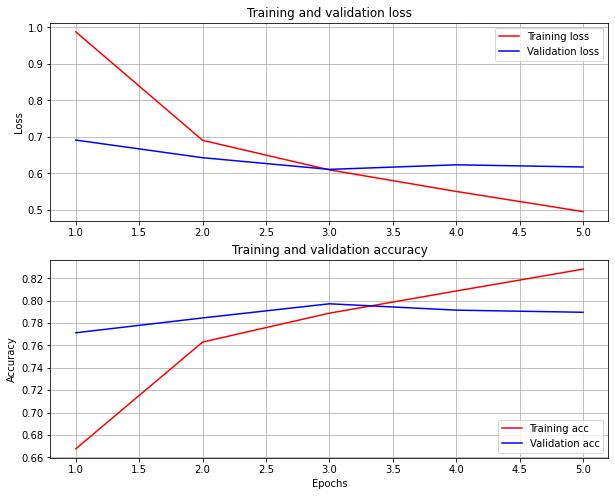

In [21]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 8))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.grid(True)
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

### Testing on Examples

In [22]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : estimated intent: {results[i]}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'Will I be making my own pasta for this recipe or using the packaged store bought kind?'
]

results = tf.nn.softmax(classifier_model(tf.constant(examples)))

In [23]:
binarizer.classes_


array(['answer_question_external_fact', 'answer_question_recipe_steps',
       'ask_question_ingredients_tools', 'ask_question_recipe_steps',
       'ask_student_question', 'chitchat', 'misc', 'request_next_step',
       'return_list_ingredients_tools', 'return_next_step', 'stop'],
      dtype='<U30')

In [24]:
intents=binarizer.inverse_transform(results.numpy())

In [25]:
print_my_examples(examples, intents)


input: Will I be making my own pasta for this recipe or using the packaged store bought kind? : estimated intent: ask_question_ingredients_tools



### Saving the Model


In [50]:
classifier_model.save("drive/MyDrive/apcc/model_smallbert_l2_h256_a4_ic.h5")

In [1]:
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 6.9 MB/s 
     |████████████████████████████████| 588.3 MB 18 kB/s 
     |████████████████████████████████| 1.7 MB 47.9 MB/s 
     |████████████████████████████████| 439 kB 62.2 MB/s 
     |████████████████████████████████| 6.0 MB 26.4 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.1

In [3]:
from keras.models import load_model
import pandas as pd
import tensorflow as tf
import tensorflow_text as text
import tensorflow_hub as hub

my_model = load_model('drive/MyDrive/apcc/model_ic.h5', custom_objects={'KerasLayer': hub.KerasLayer})

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [10]:
import numpy as np
predictions = tf.nn.softmax(my_model.predict(["Will I be making my own pasta for this recipe or using the packaged store bought kind?"]))
index = np.argmax(predictions)
labels = ['answer_question_external_fact', 'answer_question_recipe_steps',
       'ask_question_ingredients_tools', 'ask_question_recipe_steps',
       'ask_student_question', 'chitchat', 'misc', 'request_next_step',
       'return_list_ingredients_tools', 'return_next_step', 'stop']
print("intent: ", labels[index])
print("score: ", np.amax(predictions))

1/1 [==============================] - 1s 828ms/step
intent:  ask_question_ingredients_tools
score:  0.9591849
